In [73]:
# %pip install sentence_transformers
# %pip install fastapi
# %pip install uvicorn
# %pip install scikit-learn
# %pip install joblib
# %pip install wordcloud

# import sentence_transformers
# from sentence_transformers import SentenceTransformer

In [74]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputClassifier
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report
import numpy as np
import joblib
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de nltk si no están disponibles
# nltk.download('stopwords')

# Combinar stopwords de nltk con otras posibles palabras irrelevantes
my_stop_words = {'to-read', 'rating-top', 'literature', 'not-interested'}
stop_words = set(my_stop_words)
stop_words = stop_words.union(set(stopwords.words('english')))
stop_words = stop_words.union(set(stopwords.words('spanish')))
stop_words = stop_words.union(set(stopwords.words('french')))
stop_words = stop_words.union(set(stopwords.words('italian')))

# 1. Cargar el dataset
df = pd.read_csv('../data/processed/books.csv')

# 2. Combinar título y blurb como entrada textual
df['text'] = df['book_title'].fillna('') + '. ' + df['blurb'].fillna('')

# 3. Procesar los tags: convertirlos en listas y filtrar stop-words
def filter_stopwords(tags):
    """
    Filtra las stop-words de una lista de etiquetas.
    """
    return [tag for tag in tags if tag.lower() not in stop_words]

df['tags'] = df['tags'].apply(lambda x: filter_stopwords([t.strip() for t in str(x).split(',')]))

# 4. Binarización multilabel
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['tags'])

# 5. Generar embeddings con un modelo multilingüe
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# 6. Entrenar modelo multilabel
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))
clf.fit(X_embeddings, Y)

# 7. Guardar modelo y objetos necesarios
joblib.dump(clf, '../model/book_tagging_pipeline.joblib')
joblib.dump(mlb, '../model/book_tagging_pipeline_mlb.joblib')
joblib.dump(model, '../model/book_tagging_pipeline_sentence_bert.joblib')

# ...existing code...

# 8. Función para predecir tags de nuevos libros
def predict_tags(titles, blurbs, threshold=0.3, stop_words=None):
    """
    Predice etiquetas para nuevos libros.
    
    Args:
        titles (list): Lista de títulos de libros.
        blurbs (list): Lista de descripciones de libros.
        threshold (float): Umbral para convertir probabilidades en etiquetas binarias.
        stop_words (set): Conjunto de etiquetas que deben ser filtradas.
        
    Returns:
        list: Lista de listas con las etiquetas predichas (sin las stop words).
    """
    if stop_words is None:
        stop_words = set()  # Si no se proporcionan stop words, usar un conjunto vacío.
    
    texts = [t + '. ' + b for t, b in zip(titles, blurbs)]
    X_test = model.encode(texts)
    
    # Obtener las probabilidades de predicción
    preds_proba = np.array([proba[:, 1] for proba in clf.predict_proba(X_test)]).T
    
    # Aplicar el umbral para convertir probabilidades en etiquetas binarias
    preds = (preds_proba >= threshold).astype(int)
    
    # Invertir la binarización para obtener las etiquetas originales
    tag_lists = mlb.inverse_transform(preds)
    
    # Filtrar las etiquetas que están en stop_words
    filtered_tags = [[tag for tag in tags if tag not in stop_words] for tags in tag_lists]
    return filtered_tags

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

In [75]:
# Ejemplo de predicción de un libro inventado
new_titles = ["La conspiración del universo"]
new_blurbs = ["Una historia que entrelaza ciencia, fe y filosofía para revelar los secretos de la creación."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['astronomy', 'philosophy', 'religion', 'science']]


In [76]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en inglés
new_titles = ["Treasure Island"]
new_blurbs = ["Treasure Island is an adventure novel by Scottish author Robert Louis Stevenson, narrating a tale of buccaneers and buried gold."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [77]:
# Ejemplo generación de embeddings para la "Isla del Tesoro" en español
new_titles = ["La isla del tesoro"]
new_blurbs = ["La isla del tesoro es una novela de aventuras del autor escocés Robert Louis Stevenson, que narra una historia de bucaneros y oro enterrado."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'fiction', 'literary-criticism']]


In [78]:
# Ejemplo generación de embeddings para "El Quijote"
new_titles = ["Don Quijote de la Mancha"]
new_blurbs = ["Don Quijote de la Mancha es una novela escrita por el español Miguel de Cervantes Saavedra. Publicada su primera parte con el título de El ingenioso hidalgo don Quijote de la Mancha a comienzos de 1605, es una de las obras más destacadas de la literatura española y la literatura universal."]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)
print(predicted_tags)

[['catholic', 'classics', 'spain']]


In [79]:
# Ejemplo de predicción de etiquetas
new_titles = ["La conspiración del universo", "El arte de la guerra", "Cien años de soledad"]
new_blurbs = [
    "Una historia que entrelaza ciencia, fe y filosofía para revelar los secretos de la creación.",
    "Un tratado clásico sobre estrategia militar y liderazgo.",
    "Una obra maestra de la literatura que explora la historia de una familia en un pueblo ficticio."
]
predicted_tags = predict_tags(new_titles, new_blurbs, threshold=0.3, stop_words=my_stop_words)

# Print each item in a new line
for tags in predicted_tags:
    print(tags)

['astronomy', 'philosophy', 'religion', 'science']
['communism', 'history', 'war']
['children', 'christianity', 'classics', 'fiction', 'memoir']


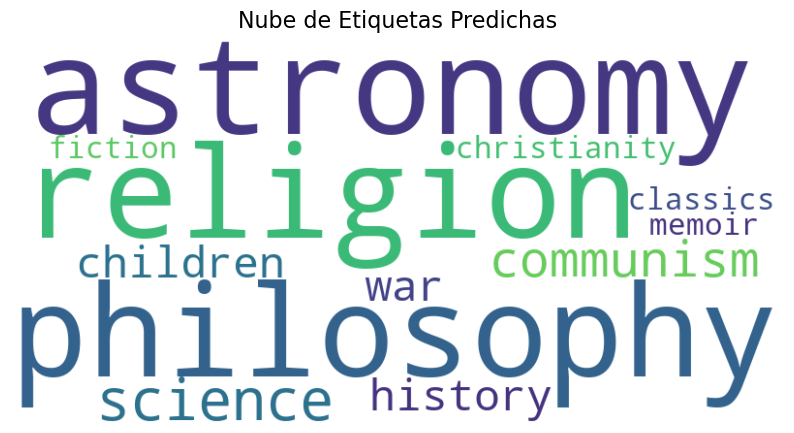

In [80]:
# Contar la frecuencia de las etiquetas
all_tags = [tag for tags in predicted_tags for tag in tags]
tag_counts = Counter(all_tags)

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(tag_counts)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Etiquetas Predichas", fontsize=16)
plt.show()